# Dzień trzeci DWthon - Hack Outside the Box 

### Celem jest wynajdywać wyróżniające cechy dla grup 80/20

To jest krok dalej od tego, że wiemy o zasadzie 80/20. Teraz próbujemy nauczyć się opisać obiekty (produkty, klienci, zamówienia itd) przy pomocy cech, które wyróżniają najważniejsze (to na czym nam zależy). Dzięki czemu możemy szybciej, łatwie i efektywniej ustawiać priorytety i zarządzać swoją pracą.

### Zanim zaczniemy | ważne (!)

Każdy dzień DWthon - hack outside the box ma dedykowaną ankietę. Wypełnij ją zanim przejdziesz do nauki. Zajmie Ci to tylko 3 minutki ;) 

### [Wypełnij ankietę](https://bit.ly/2N13YLk)  i mierz deltę swego rozwoju :) 

### Gdzie zadawać pytania ❓ 

Jeśli napotkasz trudności podczas wykonywania zadań z tego notebooka, to koniecznie napisz w kanale [dwthon_day3](https://bit.ly/2N0iCCw)

Pamiętaj, aby szczegółowo doprecyzować, z czym masz problem. Najlepiej wrzuć screen z kodem swoim lub błędem, który widzisz i napisz, którego zadania dotyczy :) 

In [2]:
%%html
<iframe style="height:500px;width:100%" src="https://www.youtube.com/embed/QzfFluxbkyw" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>

### Krok po kroku 

Nagrałem dla Ciebie także materiał wideo "krok po kroku". W wideo poniżej znajduje się dokładnie to, co w tym notebooku tylko tłumaczę wszystko, aby ułatwić Ci pracę i zrozumienie zagadnień i zadań :) Obejrzyj, jeśli potrzebujesz takiego dodatkowego wsparcia. 

In [1]:
%%html
<iframe style="height:500px;width:100%" src="https://www.youtube.com/embed/bH8GIJLKMsE" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>

## Biblioteki

Oprócz `pandas` wczytajmy graficzne `matplotlib` z ustawieniami (trochę będzie wykresów, w szczególności w dodatkowej części).

In [2]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (12, 5)

## Wczytajmy dane

Pamiętasz, jak to zrobić, prawda? Używamy do tego funkcji `pd.read_hdf`.

In [3]:
df = pd.read_hdf("../input/data.h5")

print(df.shape)
df.sample(5)

(820906, 9)


,order_id,customer_id,product_id,quantity,price_unit,price_total,country_id,order_date,is_canceled
778843,50672,2813,11,3,375,1125,0,2010-11-17 14:31:00,False
524183,33915,460,64,3,254,762,0,2010-04-13 13:21:00,False
394722,24735,4268,920,1,85,85,0,2011-12-05 12:46:00,False
248551,17090,1863,278,10,165,1650,0,2011-09-15 14:05:00,False
521565,33738,3917,453,6,165,990,0,2010-04-11 10:47:00,False


## Zmienna docelowa

Chcemy wiedzieć, dokąd dążymy. Trzeba wybrać grupy/segmenty - wyłonić "mniejszość", która daje "większość".

Przypomnijmy kod z poprzedniej lekcji i obliczmy sumę skumulowaną.

In [4]:
df_customers = (
    df[ ["price_total", "customer_id"] ]
    .groupby("customer_id")
    .agg("sum")
    .reset_index()
    .sort_values(by="price_total", ascending=False)
    .rename(columns={"price_total": "customer_price_total"})
)


df_customers["cumsum"] = df_customers["customer_price_total"].cumsum()
df_customers.head(5)

,customer_id,customer_price_total,cumsum
448,448,61130939,61130939
907,907,53007160,114138099
2647,2647,33695110,147833209
179,179,31039769,178872978
66,66,29774259,208647237


Teraz chcemy stworzyć nową kolumnę o nazwie `most_revenue_customer`, gdzie wartością może być `True` lub `False`. 

Wartość `True` będzie wtedy, kiedy konkretnie ten klient jest w gronie ~20% procent, które wytwarzają 80% przychodów.

In [5]:
value_80prc = int(df["price_total"].sum() * 0.8)
df_customers["most_revenue_customer"] = df_customers["cumsum"] < value_80prc

df_customers["most_revenue_customer"].value_counts()

False    4555
True     1324
Name: most_revenue_customer, dtype: int64

Na końcu pojawiło się `value_counts()`. Zapamiętaj tę funkcję, bo często warto mieć ją pod ręką, aby sprawdzić, jakie są unikalne wartości w kolumnie i w jakiej ilości.

W naszym przypadku mamy `1324` klientów, którzy należą do grona  kluczowych klientów dla biznesu, ponieważ przynoszą firmie 80% przychodów. Jeśli "zgubimy" tych klientów, to firma będzie miała -80% przychodów. Jeśli pominiemy resztę, firma będzie miała jedynie -20%. Czuć różnicę, prawda? 

Swoją drogą w `.value_counts` można znormalizować wynik (podając argument `normalize=True`). Zobaczysz wtedy wynik wyrażony w procentach. Czasem to jest wygodne. Zobacz, jak to się robi 👀.

In [6]:
df_customers["most_revenue_customer"].value_counts(normalize=True)

False    0.774792
True     0.225208
Name: most_revenue_customer, dtype: float64

Widzimy że `most_revenue_customer` (czyli wartość `True`) ma **22,5%** (przemnożyłem w locie `0.225208 * 100%` i zaokrągliłem do `22,5%` 😉).


Zapiszmy do osobnego zbioru klientów, którzy wygenerowali 80% przychodu. Do tego użyjmy `unique()`, który zwróci nam listę ID klientów (unikalnych ID, czyli każdy ID będzie występował dokładnie raz). Dodatkowo wynik konwertujemy do zbioru (czyli `set`), ale to robimy po to, aby szybciej się liczyło, jak będziemy dalej używać tego zbioru (sprawdzanie obecności czy dany klient/produkt w zbiorze wykonuje się wtedy zauważalnie szybciej).

In [7]:
top_customers = set(df_customers[ df_customers["most_revenue_customer"] ]["customer_id"].unique())
len(top_customers)

1324

Możemy teraz też dodać nową kolumnę `most_revenue_customer` w oryginalnym `df`. Używając funkcji `map` iterujemy wartość po wartości i sprawdzamy, czy klient (`customer_id`) jest w zbiorze `top_customers`. Są dwie możliwe odpowiedzi: tak lub nie (`True`/`False`).

In [8]:
df["most_revenue_customer"] = df["customer_id"].map(lambda x: x in top_customers)
df["most_revenue_customer"].value_counts()

True     539072
False    281834
Name: most_revenue_customer, dtype: int64

Dodatkowo w tym przypadku pojawiła się `lambda`, tak zwana funkcja anonimowa. Akurat teraz nie będę wchodzić w szczegóły. Najważniejsze w tej funkcji `lambda x: x in top_customers` jest ciało tej funkcji, czyli ten warunek `x in top_customers`. Gdzie `x` to jest nazwa zmiennej, w tym przypadku `x` to `customer_id`. 

##### 🤔Jeśli na początek jest wiele niejasności i czujesz pewny dyskomfort 🤯, to jest normalne. Potrzebujesz trochę więcej czasu, aby to przyswoić. Też na ten temat jest osobny online kurs ["Zacznij analizować dane w Python"](https://bit.ly/3l3Hypw), gdzie przez 3 tygodnie jest więcej szczegółów między innymi o *lambda*, *pandas* i *numpy*. Wszystko, czego potrzebujesz, aby lepiej zacząć analizować dane w Python. Nie próbuj wszystkiego zrozumieć na raz! 



Zobaczmy też to w procentach.

In [9]:
df["most_revenue_customer"].value_counts(normalize=True)

True     0.656679
False    0.343321
Name: most_revenue_customer, dtype: float64

Jak widać, najwięcej "wierszy" w naszym `df` wygenerowali klienci z segmentu `most_revenue_customer`. Co sugeruje, że ci klienci robili:
- dużo zamówień; 
- zamawiali dużo różnych produktów w jednym zamówieniu. 

Sprawdzimy oba przypadki, aby lepiej zrozumieć, **co należy zrobić**, aby trafić do segmentu `most_revenue_customer`.

W takim razie wiemy, do czego chcemy dążyć. To i tak już dużo... 💪 Pomyśl przez chwilę, jak często wiesz, gdzie (i tym bardziej po co) zmierzasz? 🤔

## Co z tego, że wiemy "kto", pytanie "jak"?
Zarządzanie swoją energią jest kluczowe w życiu 🔋! Masz bardzo ograniczoną i skończoną liczbę energii. Po Twojej stronie jest decyzja, komu ją oddasz. Pomyśl, masz w kieszeni 100 zł. Możesz je wydać na wiele różnych sposobów, prawda? Zaczynając od tego, że możesz wyrzucić przez okno czy zakopać w ziemi, ale też możesz kupić książkę czy mini kurs i zainwestować w swój rozwój. Każda z tych decyzji wpłynie na to, gdzie będziesz za moment. To gdzie jesteś teraz to suma (skutek) wszystkich Twoich (świadomych lub nieświadomych) decyzji.


#### Dlatego warto dbać o to, w jaki sposób zarządzasz swoją energią?

Tak się składa, że część klientów przynosi większe dochody. To brzmi, że warto, aby takich klientów było więcej, prawda? Pytanie: jak można rozpoznać takich klientów patrząc w przyszłość, nie w przeszłość? Właściwie, jak możemy opisać takiego klienta?

👀Zobacz, przed tym jak klient kupi jest bardzo dużo innych kosztów, np. koszty na reklamę. Dlatego fajnie byłoby z góry wiedzieć jak, czym się charakteryzuje "idealny klient" i najwięcej swojej uwagi i energii inwestować właśnie w pozyskanie takich osób, które potrzebują Twojego rozwiązania (produktu lub usługi). 

Innymi słowy, chcemy zrozumieć, czym się różnią "idealni klienci" od innych klientów. Swoją drogą tutaj słowa "idealne" można używać w wielu kontekstach: idealny klient, idealny produkt, idealne zamówienie, idealny okres czasu itd. To oznacza, że mamy sytuację, kiedy więcej można zrobić naturalnie łatwiej, bo jesteśmy we właściwym miejscu, z właściwym rozwiązaniem dla właściwych klientów itd.


To brzmi, że każdy z tych wymiarów/obiektów (klient, produkt, zamówienie itd) posiada pewne właściwości, atrybuty lub cechy, dzięki którym możemy odróżnić "idealne" od "innych". W uczeniu maszynowym (ang. `machine learning`) takie właściwości nazywamy cechami (ang. `features`). Istnieje nawet proces (który jest bardzo ważny), jak tworzenie (wymyślanie) nowych cech, które lepiej opiszą obiekt (klient, produkt itd). Ten proces ma swoją nazwę - inżynieria cech (ang. `feature engineering`). 

Właśnie tym się zajmiemy :) 


## W jaki sposób możesz opisać klienta?

Tworzenie nowych cech to bardziej sztuka niż nauka. Najlepiej to pokazywać na przykładach, bo nie ma uniwersalnego algorytmu. 

👀 Na pierwszy rzut oka może wydawać się, że mamy bardzo mało informacji o klientach, produktach (np. tylko ID), ale tak naprawdę jest tam znacznie więcej informacji, którą należy wydobyć.

Zaczniemy od prostego przykładu związanego z klientami.

### Ile klient ma zamówień?

In [10]:
df_customer_orders = (
    df[ ["customer_id", "order_id"] ]
        .groupby(["customer_id"])
        .agg(lambda x: len(set(x)) )
        .reset_index()
        .rename(columns={"order_id": "count_orders"})
        
)

df_customer_orders["most_revenue_customer"] = df_customer_orders["customer_id"].map(lambda x: x in top_customers)
df_customer_orders

,customer_id,count_orders,most_revenue_customer
0,0,159,True
1,1,40,True
2,2,30,True
3,3,9,False
4,4,14,True
...,...,...,...
5874,5874,2,False
5875,5875,1,False
5876,5876,1,False
5877,5877,1,False


☝️ Zwróć uwagę, że od razu też dodaliśmy nową kolumnę do `df_customer_orders` o nazwie `most_revenue_customer`, która ma `True` lub `False` jako wartość.

Widzimy, że `customer_id=0` ma 59 zamówień, `customer_id=5878` ma dwa zamówienia. Zróbmy na szybko `double-check`, aby upewnić się, że robimy to dobrze.

In [11]:
df[ df["customer_id"] == 5878 ][ ["customer_id", "order_id", "product_id", "order_date"] ]

,customer_id,order_id,product_id,order_date
805795,5878,52178,694,2010-11-30 15:52:00
806122,5878,52202,694,2010-11-30 18:46:00


Jak widać, wszystko zgadza się - `customer_id` ma dwa zamówienia. Co ciekawe to był ten sam produkt (`product_id=694`) i drugie zamówienie powstało za ~3h (2:54h). Potem już nie wrócił. Na podstawie tego można wymyślić już szereg rzeczy, co jeszcze można sprawdzić, ale na razie zostawmy to.

Jak na razie już oprócz `customer_id` mamy drugą cechę `count_orders`, czyli ile zamówień dokonał ten klient.

Zacznimy sprawdzać, czy faktycznie liczba zakupów "pomaga" trafić do segmentu klientów `most_revenue_customer`.

In [12]:
(
    df_customer_orders[ ["most_revenue_customer", "count_orders"] ]
    .groupby("most_revenue_customer")
    .agg(['mean', 'min', 'max', 'median', 'std'])
)

count_orders                           
                              mean min  max median        std
most_revenue_customer                                        
False                     3.446542   1   30      2   2.913319
True                     21.305891   1  468     15  27.836488

### Wnioski

- `min=1` dla `most_revenue_customer=True`
Widzimy, że jest przypadek, kiedy klient ma tylko jedno zamówienie, ale trafił do `most_revenue_customer` (warto sprawdzić, o co chodziło w tym przypadku, pewnie o rozmiar zamówienia);
- `max` dla `most_revenue_customer=True` 468, w przypadku `most_revenue_customer=False` maksymalna wartość 30. Brzmi, że każdy kto ma więcej niż 30 zamówień trafia do `most_revenue_customer`. Prawdopodobnie to jest próg, który przekracza pewną kwotę (taka hipoteza, warto sprawdzić).
- mediana (czyli połowa) dla `most_revenue_customer=True` jest 15 (to oznacza, że połowa klientów posiada co najmniej 15+ zamówień lub odwrotnie) w przypadku `most_revenue_customer=False` połowa klientów ma tylko 3 zamówienia.

Nasuwa się jeszcze kilka innych wniosków.


Czas na zadania. Przeprowadź podobną analizę dla produktów.

## Zadanie 3.1


Ostatnio przygotowaliśmy zbiór `top_customers`. Teraz zróbmy podobnie tylko dla produktów i wynik zapiszmy do zmiennej o nazwie `top_products`.

### 💡 Podpowiedźi

1. Najpierw trzeba wyliczyć `most_revenue_product` z możliwymi odpowiedziami `True` lub `False`.  
2. W tym celu warto policzyć `cumsum` dla produktów (czyli pogrupwać).  
3. Wyżej już to zrobiliśmy dla  `df_customers`, teraz ma powstać identyczna `df_products`. 
4. Załóż, że większość to 80% `value_80prc = int(df["price_total"].sum() * 0.8`.
5. Wtedy możesz policzyć `most_revenue_product` w taki sposób `df_products["most_revenue_product"] = df_products["cumsum"] < value_80prc`.   
6. I na koniec `set(df_products[ df_products["most_revenue_product"] ]["product_id"].unique())`.
7. Wynik przypisz do zmiennej z pkt. 6 `top_products`.


### Jeśli nadal masz pytania, śmiało pytaj 🙏 na slacku na kanale [#dwthon_day3](https://bit.ly/3qzFjv0)! Pamiętaj od pytań rozpoczyna się nauka. To jest bardzo dobrze, że masz pytanie :) 

In [ ]:
### YOUR CODE HERE

Jak **wykonasz** zadanie, należy zrobić:

1. Zrzut ekranu na którym widać rozwiązania, wtedy dostaniesz bonus :)
2. Wrzucić rozwiązanie na slacku do pokoju **[#dwthon_day3_done](https://stat.dataworkshop.eu/r?u=https://dataworkshopclub.slack.com/archives/C01QFU9MW8K)**
3. Dostać bonus za dobrą robotę 💪 i jutro będzie kolejna porcja.

*Uwaga! Jeśli masz problem z jakimś zadaniem, czegoś nie wiesz, to pamiętaj, że możesz zadawać pytania! Na tym polega nauka :) Pytania związane z 2 dniem DWthon zadawaj w kanale [#dwthon_day3](https://stat.dataworkshop.eu/r?u=https://dataworkshopclub.slack.com/archives/C01QFN93AAE)*.

## Dodatkowe zadania

Warto pójść krok dalej, jeśli masz energię i "rozebrać" 🤔 zamówienia na mniejsze "kawałki". Każde zamówienie składa się z produktów. 

Sprawdźmy np. jakie produkty klient kupił co najmniej raz. 

In [13]:
df_customer_products = (
    df[ ["customer_id", "product_id"] ]
        .groupby(["customer_id"])
        .agg(lambda x: len(set(x)) )
        .reset_index()
        .rename(columns={"product_id": "count_unique_products"})
        
)

df_customer_products["most_revenue_customer"] = df_customer_products["customer_id"].map(lambda x: x in top_customers)
df_customer_products

,customer_id,count_unique_products,most_revenue_customer
0,0,93,True
1,1,184,True
2,2,139,True
3,3,40,False
4,4,11,True
...,...,...,...
5874,5874,46,False
5875,5875,21,False
5876,5876,69,False
5877,5877,33,False


Widzimy, że np. `customer_id=0` kupił co najmniej w jednej sztuce 93 produkty. Dla przykładu `customer_id=5878` kupił tylko jeden rodzaj produktu. Zróbmy teraz podobną analizę jak powyżej. Pomogę Ci.

In [14]:
(
    df_customer_products[ ["most_revenue_customer", "count_unique_products"] ]
    .groupby("most_revenue_customer")
    .agg(['mean', 'min', 'max', 'median', 'std'])
)

count_unique_products                             
                                       mean min   max median         std
most_revenue_customer                                                   
False                             47.309330   1   408     32   49.811765
True                             189.253776   1  2353    152  174.096217

## 🧠 Włączmy myślenie krytycznie

Pomyśl co to oznacza? Wyciągnij wnioski i porozważaj (postaw hipotezy, które warto sprawdzić).

## 🤝🗣️ Uruchom kooperację i komunikację


#### ☝️ Podziel się swoimi przemyśleniami na slacku **[#dwthon_day3_ideas](https://stat.dataworkshop.eu/r?u=https://dataworkshopclub.slack.com/archives/C01QFNACP8A)**. Jeśli masz pomysł, ale nie masz kodu - poproś na slacku o pomoc, aby ktoś pomógł Ci napisać kod. Natomiast jeśli masz kod, to koniecznie podziel się. Dzięki temu ktoś inny będzie w stanie łatwo powtórzyć i podzielić się swoimi przemyśleniami. Dzięki temu każdy zyskuje :).


Uwaga! Aby to było czytelne, proponuję dodawać tagi do wiaodmości na samym początku.

Na przykład.

```
#df_customer_products

Moje wnioski ...
1. ...
2. ...
3. ...
```

Zawartość pisz, jak Ci jest wygodnie, ale zacznijmy od tagu `#df_customer_products`, dzięki temu łatwiej będzie filtrować wśród innych wiadomości.

## 🧠 Włączmy myślenie krytycznie


Tak się składa, że w naszym życiu ważną rolę odgrywa czas. Jeśli o tym porozważasz, to branie pod uwagę osi czasu jest bardzo istotne. Wyobraź sobie, że od jutra zakazują pojęcia czasu (podczas "pandemii" nawet to może "przejść" 😉), to co wtedy?  To co to oznacza dla Ciebie?


No właśnie. Ciężko. Czas jest bardzo istotny. Od tego zależy większość naszych aktywności. W kontekście tego zadania, czas bardzo wpływa na to, kiedy kupujemy prezenty.


Z mojego doświadczenia wynika, że w analizie danych ważne są konteksty. Czas jest jednym z kluczowym kontekstów, o którym zawsze warto pamiętać! Pokażę Ci na przykładzie, dlaczego zwracam tak dużą uwagę na "czas".

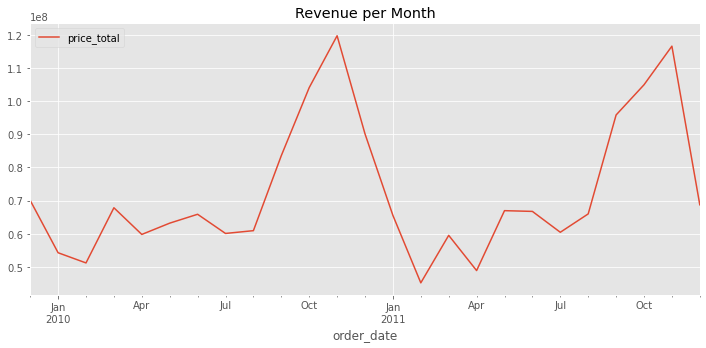

In [15]:
df.index = df.order_date
df[ ['price_total'] ].resample('m').agg("sum").plot(title="Revenue per Month");

Na wykresie widać, że przychody bardzo zależą od miesiąca. Właściwie nawet można pokazać miesiące, w których materializuje się 80% przychodów. Też widać powtarzalność. Późna jesień i początek zimy brzmią jako najatrakcyjniejsze okresy w sprzedaży.

Kilka zdań technicznych.

- `df.index = df.order_date` przypisaliśmy do indeksu daty, aby można było stosować `resample`.
- `resample('M')` to jest funkcja, która bardzo ułatwia życie przy pracy z osią czasu. Podobny efekt można osiągnąć też przy pomocy `groupby`, ale więcej trzeba się namęczyć. 
- parametr `M` w `resample` oznacza `month` (czyli miesiąc), pozbieraj dane per miesiąc, można tam wstawić `d` od `day` (dzień) lub nawet `7d`, wtedy będzie co 7 dni. Sprawdźmy :)

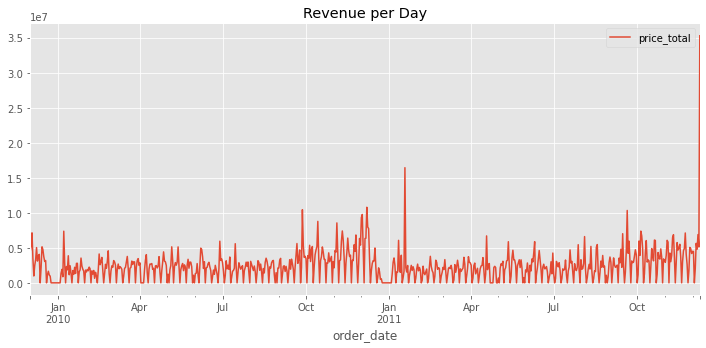

In [16]:
df[ ['price_total'] ].resample('d').agg("sum").plot(title="Revenue per Day");

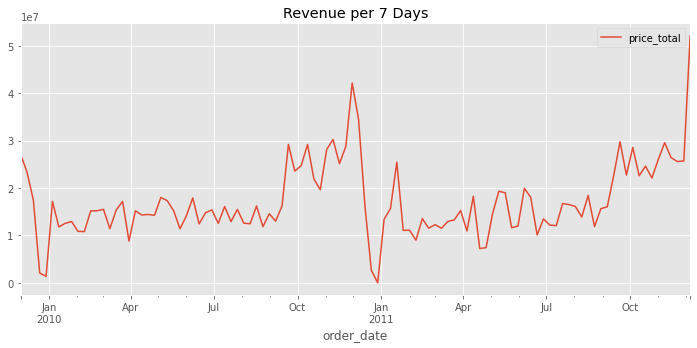

In [17]:
df[ ['price_total'] ].resample('7d').agg("sum").plot(title="Revenue per 7 Days");

- `agg("sum")` oznacza funkcję agregującą sumę, ale może być coś innego, np. `max`, `min`, `median`, `std` lub wszystko na raz.  Sprawdźmy.  

⌛️ Uwaga, ta komórka liczy się dłużej!

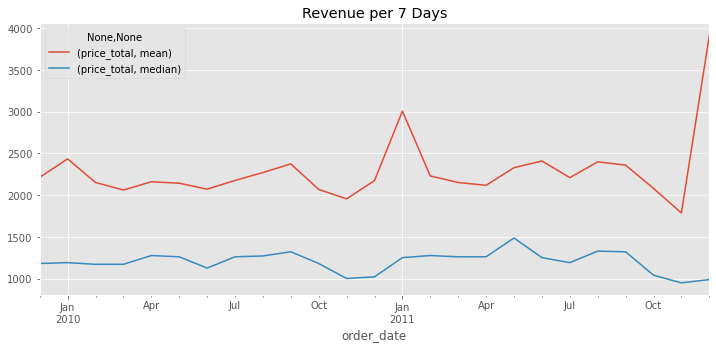

In [18]:
df[ ['price_total'] ].resample('1m').agg(["mean", "median"]).plot(title="Revenue per 7 Days");

Widac, że czasem `max` znacząco wyróżnia się. Brzmi jako temat, o którym można porozważać "dlaczego" tak się dzieje.

Dodatkowo możemy zrobić  `count` (w sztukach), tylko wtedy przełączamy się na `product_id` lub `order_id`. Sprawdźmy liczbę zamówień per miesiąc.

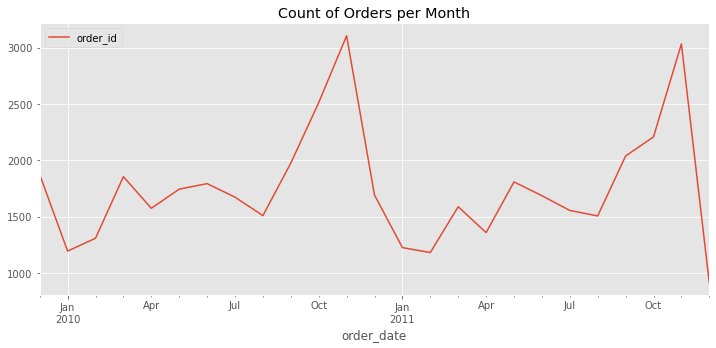

In [19]:
df[ ['order_id'] ].resample('1m').agg(lambda x: len(set(x)) ).plot(title="Count of Orders per Month");

## 🤝🗣️ Uruchom kooperację i komunikację


W tej lekcji już było poruszonych wiele pomysłów, co można posprawdzać w danych. Zaczęlismy od tego, że badaliśmy `top_clients`. Można zrobić podobnie dla `top_products`!




#### ☝️ Podziel się swoimi przemyśleniami na slacku **[#dwthon_day3_ideas](https://bit.ly/3rs5m8N)**. Jeśli masz pomysł, ale nie masz kodu - poproś na slacku o pomoc, aby ktoś pomógł Ci napisać kod. Natomiast jeśli masz kod, to koniecznie podziel się. Dzięki temu ktoś inny będzie w stanie łatwo powtórzyć i podzielić się swoimi przemyśleniami. Dzięki temu każdy zyskuje :).

Uwaga! Aby to było czytelne, proponuję dodawać tagi do wiadmości na samym początku.

Na przykład.
```
#top_products

Moje wnioski ...
1. ...
2. ...
3. ...
```

Zawartość pisz, jak Ci jest wygodnie, ale zacznijmy od tagu `#top_products`, dzięki temu łatwiej będzie można filtrować wśród innych wiadomości.

--- 


## Twój Feedback 

Daj mi znać koniecznie, co sprawiło Ci przyjemność, co trudność oraz czego udało się nauczyć w tej krótkiej [ankiecie](https://bit.ly/3qxsIJ1). Pozwoli mi ona ulepszyć zadania, a Tobie lepiej trakować swój rozwój: win-win 😇 

## Widzimy się jutro!  🙌